## Use of VFA methods
The goal of this notebook is to show if it is possible to use VFA methods in the Slimevolley gym environment.

In [1]:
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
import gym
import slimevolleygym
from itertools import count, product


# Define our input folders and output files
DATADIR = join('..', 'data')
MODELDIR = join('..', 'models')
SAMPLES_FILE = 'sampled_states.csv'
CENTROIDS_FILE = 'centroids_10K.csv'

We read the file `sampled_states.csv`. This is a database which contains 1M observations of the simulation of the agent playing with the opponent, both using the baseline policy (based on neural net)

In [2]:
ss = pd.read_csv(join(DATADIR, SAMPLES_FILE))

We create a normalized dataframe `ss_norm`.

In [3]:
scaler = MinMaxScaler()
ss_norm = scaler.fit_transform(ss)
ss_norm = pd.DataFrame(ss_norm, columns=['x_agent', 'y_agent', 'xdot_agent', 'ydot_agent',
                                         'x_ball', 'y_ball', 'xdot_ball', 'ydot_ball', 'x_opponent',
                                         'y_opponent', 'xdot_opponent', 'ydot_opponent'])            

We create a `MiniBatchKMeans` estimator with 10K clusters and a batch size of 2048 and fit it with our normalized sampled states dataframe. The purpose of this is to reduce the information of our sampled states in 10K clusters, which will be the centroids of the RBF used in the next cells.

In [4]:
# mbkm_model = MiniBatchKMeans(n_clusters=10_000, random_state=0, batch_size=2048, verbose=True)
# mbkm_model.fit(ss_norm)  # 1M samples, around 5m 30s with current setup

We save the `cluster_centers_` from our `mbkm_model`in a file called `centroids_10K.csv`. This step is done so that we do not need to execute the clustering algorithm every time we want to use the centroids.

In [5]:
# head = 'x_agent,y_agent,xdot_agent,ydot_agent,' \
#         'x_ball,y_ball,xdot_ball,ydot_ball,' \
#         'x_opponent,y_opponent,xdot_opponent,ydot_opponent'
        
# np.savetxt(fname=join(DATADIR, CENTROIDS_FILE),
#         X=mbkm_model.cluster_centers_,
#         fmt='%.5f',
#         delimiter=',',
#         header=head,
#         comments='')

We save the information of the centroids from our file in a dataframe called `centroids`. The shape of this dataframe will be 10K rows (number of clusters selected in our algorithm) by 12 columns (number of dimensions of the states of our environment).

In [6]:
centroids = pd.read_csv(join(DATADIR, CENTROIDS_FILE))

We create the definition of the function for the feature vector, which is encapsulated in a Featurizer class.

In [7]:
class Featurizer:
    def __init__(self, observation_space, centroids, sigma=0.5):
        self.n_dim = len(observation_space.low)
        self.centroids = np.array(centroids)     
        self.sigma = sigma
        self.n_parameters = len(self.centroids)
    def feature_vector(self, s):
        dist = (self.centroids - np.array(s))**2
        x = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return x

# Example for normalized state [0]
slime_env = gym.make('SlimeVolley-v0')
featurizer = Featurizer(slime_env.observation_space, centroids)
x = featurizer.feature_vector(ss_norm.iloc[0, :])
x

array([0.29 , 0.012, 0.02 , ..., 0.005, 0.075, 0.006])

In [8]:
class ValueFunction:
    def __init__(self, featurizer, n_actions):
        self.n_actions = n_actions
        n_parameters = featurizer.n_parameters
        self.parameters = np.zeros((n_actions, n_parameters), dtype=np.float_) 
        self.featurizer = featurizer
        
        # estimar el valor de un estado y una acción dados
    def value(self, observation, action):
        features = self.featurizer.feature_vector(observation)
        return features.dot(self.parameters[action,:])

        # actualiza con state, action y target
    def update(self, observation, action, target, alpha):
        features = self.featurizer.feature_vector(observation)
        estimation = features.dot(self.parameters[action,:])
        delta = alpha * (target - estimation)*features
        self.parameters[action,:] = self.parameters[action,:] + delta
        
def get_action(observation, q_value_function, epsilon = 0.0):
    n_actions = q_value_function.n_actions
    if np.random.binomial(1, epsilon) == 1:
        return np.random.randint(n_actions)
    values = []
    for action in range(n_actions):
        values.append(q_value_function.value(observation, action))
    return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)])

def semi_gradient_sarsa(env, q, episodes, gamma = 1.0, epsilon = 0.1, alpha = 0.1):
    history = np.zeros(episodes)
    history_average = np.zeros(episodes)
    for episode in range(episodes):
        if (episode+1) % 100 == 0 and episode > 0:
            mean_G = history_average[episode-1]
            print('episodio {}: alfa = {}, epsilon = {}, retorno medio = {}'.format(episode+1, alpha, epsilon, mean_G))
        G = 0 # retorno inicial del episodio
        S = env.reset()
        A = get_action(S, q, epsilon) # accion dada por epsilon greedy respecto a q
        for t in count():
            S_next, reward, done, _ = env.step(A)
            G += reward
            A_next = get_action(S_next, q, epsilon)
            if done:
                target = reward
                q.update(S, A, target, alpha)
                break 
            target = reward + gamma * q.value(S_next, A_next)
            q.update(S, A, target, alpha)
            A = A_next
            S = S_next        
        history[episode] = G
        history_average[episode] = np.mean(history[0:episode+1])        
    return q, history, history_average

In [9]:
slime_env = gym.make('SlimeVolley-v0')
featurizer = Featurizer(slime_env.observation_space, centroids)
q = ValueFunction(featurizer, slime_env.action_space.n)
slime_q, slime_history, slime_history_average = semi_gradient_sarsa(slime_env, q, 1000) # alpha and epsilon values by default

episodio 100: alfa = 0.1, epsilon = 0.1, retorno medio = -4.878787878787879
episodio 200: alfa = 0.1, epsilon = 0.1, retorno medio = -4.85929648241206
episodio 300: alfa = 0.1, epsilon = 0.1, retorno medio = -4.846153846153846
episodio 400: alfa = 0.1, epsilon = 0.1, retorno medio = -4.857142857142857
episodio 500: alfa = 0.1, epsilon = 0.1, retorno medio = -4.865731462925852
episodio 600: alfa = 0.1, epsilon = 0.1, retorno medio = -4.874791318864775
episodio 700: alfa = 0.1, epsilon = 0.1, retorno medio = -4.86552217453505
episodio 800: alfa = 0.1, epsilon = 0.1, retorno medio = -4.863579474342929
episodio 900: alfa = 0.1, epsilon = 0.1, retorno medio = -4.863181312569521
episodio 1000: alfa = 0.1, epsilon = 0.1, retorno medio = -4.862862862862863


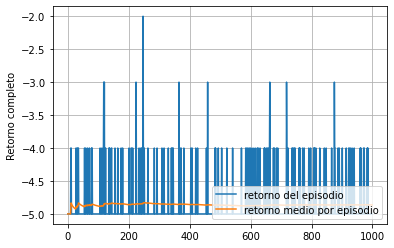

In [10]:
ax = plt.subplot(111)
plt.plot(slime_history, label="retorno del episodio")
plt.plot(slime_history_average, label="retorno medio por episodio")
plt.ylabel('Retorno completo', size=10)
ax.legend(loc='lower right')
plt.grid()
plt.show()

In [11]:
def semi_gradient_n_step_sarsa(env, q, episodes, n=1, gamma = 1.0, epsilon = 0.1, alpha = 0.1):
    history = np.zeros(episodes)
    history_average = np.zeros(episodes)
    for episode in range(episodes):
        if (episode+1) % 100 == 0 and episode > 0:
            mean_G = history_average[episode-1]
            print('episodio {}: alfa = {}, epsilon = {}, retorno medio = {}'.format(episode+1, alpha, epsilon, mean_G))
        G = 0
        S = env.reset()
        A = get_action(S, q, epsilon)
        observations, actions, rewards = {}, {}, {}
        observations[0] = S
        actions[0] = A
        rewards[0] = 0.0
        T = float('inf') 
        for t in count():
            if t < T:
                S_next, R, done, _ = env.step(A)
                observations[t+1] = S_next
                rewards[t+1] = R
                if done:
                    T = t+1
                else:
                    A_next = get_action(S_next, q, epsilon)
                    actions[t+1] = A_next
                G += R
            tau = t - n + 1
            if tau >= 0:
                target = 0.0
                for i in range(tau+1, min(tau+n,T)):
                    target += gamma**(i-tau-1) * rewards[i]
                if tau + n < T:
                    target += gamma**n * q.value(observations[tau + n], actions[tau + n])
                q.update(observations[tau], actions[tau], target, alpha)
                del observations[tau]
                del actions[tau]
                del rewards[tau]
            if tau == T-1:
                break
            A = A_next       
        history[episode] = G
        history_average[episode] = np.mean(history[0:episode+1])        
    return q, history, history_average

In [12]:
slime_q, slime_history, slime_history_average = semi_gradient_n_step_sarsa(
    slime_env, q, 1000, n = 4, alpha=0.05)

episodio 100: alfa = 0.05, epsilon = 0.1, retorno medio = -4.878787878787879
episodio 200: alfa = 0.05, epsilon = 0.1, retorno medio = -4.899497487437186
episodio 300: alfa = 0.05, epsilon = 0.1, retorno medio = -4.889632107023411
episodio 400: alfa = 0.05, epsilon = 0.1, retorno medio = -4.8922305764411025
episodio 500: alfa = 0.05, epsilon = 0.1, retorno medio = -4.889779559118236
episodio 600: alfa = 0.05, epsilon = 0.1, retorno medio = -4.893155258764608
episodio 700: alfa = 0.05, epsilon = 0.1, retorno medio = -4.898426323319027
episodio 800: alfa = 0.05, epsilon = 0.1, retorno medio = -4.889862327909888
episodio 900: alfa = 0.05, epsilon = 0.1, retorno medio = -4.885428253615128
episodio 1000: alfa = 0.05, epsilon = 0.1, retorno medio = -4.887887887887888


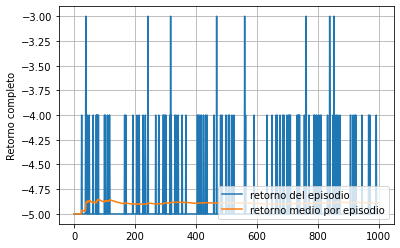

In [13]:
ax = plt.subplot(111)
plt.plot(slime_history, label="retorno del episodio")
plt.plot(slime_history_average, label="retorno medio por episodio")
plt.ylabel('Retorno completo', size=10)
ax.legend(loc='lower right')
plt.grid()
plt.show()